# **Imports 📢**

In [52]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.5 MB/s eta 0:00:00


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tensorflow_docs.vis import embed
import torchvision
from torchvision.io import read_image
from torchvision import datasets
from torchvision.utils import make_grid, save_image
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch
from torch import  nn
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
import imageio.v2 as imageio
from glob import glob

# **Inits 👶**

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_dim = 784 #28X28

num_cls = 10

batch_size = 100

lr = 0.0002

n_epochs = 100

z_size = 100

# **Utils 🧰**

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Dataset 📚**

In [4]:
train_transformers = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

test_transformers = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [5]:
train = datasets.MNIST('./content/mnist', True, train_transformers, download=True)

test = datasets.MNIST('./content/mnist', False, test_transformers, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34785451.89it/s]


Extracting ./content/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./content/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1067933.47it/s]


Extracting ./content/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9939681.74it/s]


Extracting ./content/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5291813.55it/s]

Extracting ./content/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/mnist/MNIST/raw



In [6]:
train_loader = DataLoader(train, 100, True)
test_loader = DataLoader(test, 200, False)

# **Models 🤼‍♂️**

## Generator🧙‍♂️

In [7]:
class Generator(nn.Module):
  def __init__(self, n=256):
    super(Generator, self).__init__()
    self.fc1 = nn.LazyLinear(n)
    self.fc2 = nn.LazyLinear(n*2)
    self.fc3 = nn.LazyLinear(n*4)
    self.fc4 = nn.LazyLinear(mnist_dim)

  def forward(self, z, labels):
    labels = F.one_hot(labels, num_cls)
    inputs = torch.cat([z, labels], dim=1).to(device)
    x = F.leaky_relu(self.fc1(inputs), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    y = torch.tanh(self.fc4(x))
    return y

## Discriminator 🕵️‍♂️

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.fc1 = nn.LazyLinear(1024)
    self.fc2 = nn.LazyLinear(512)
    self.fc3 = nn.LazyLinear(256)
    self.fc4 = nn.LazyLinear(1)

  def forward(self, x, labels):
    labels = F.one_hot(labels, num_cls)
    inputs = torch.concatenate([x, labels], dim=1).to(device)
    x = F.dropout(F.leaky_relu(self.fc1(inputs), negative_slope=0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), negative_slope=0.2), 0.3)
    y = torch.sigmoid(self.fc4(x))
    return y

#**Functions**

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, loss_fn):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_cls, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = loss_fn(validity, Variable(torch.ones(batch_size, 1)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, loss_fn, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_images = real_images.view(batch_size, 784).to(device)

    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = loss_fn(real_validity, Variable(torch.ones(batch_size, 1)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, num_cls, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = loss_fn(fake_validity, Variable(torch.zeros(batch_size, 1)).to(device))

    # Avg two losses
    d_loss = (real_loss + fake_loss) / 2

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

## Build models and chek them

In [ ]:
x, y = next(iter(train_loader))
noise = torch.randn(batch_size, 100).to(device)
fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
digit_labels = y.to(device)
real_data = x.view(batch_size, 784).to(device)
dis = Discriminator().to(device)
gen = Generator().to(device)

In [ ]:
loss_fn = nn.BCELoss()
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)
# Discriminator
d_outputs = dis(real_data, digit_labels)
loss_d = loss_fn(d_outputs, ones)

g_outputs = dis(gen(noise, fake_labels), fake_labels)
loss_g = loss_fn(g_outputs, zeros)

d_loss = (loss_d + loss_g) / 2

In [ ]:
#Gen
g_outputs = dis(gen(noise, fake_labels), fake_labels)
g_loss = loss_fn(g_outputs, ones)

# **Loss & Optimizers ⚖️**

In [29]:
loss_D_hist, loss_G_hist = [], []
counter = 0
dis = Discriminator().to(device)
gen = Generator().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [30]:
loss_fn = nn.BCELoss()

In [33]:
G_optimizer = optim.Adam(gen.parameters(), lr)
D_optimizer = optim.Adam(dis.parameters(), lr)

# **Train 🚅**

In [34]:
for epoch in range(n_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # real images & real label
      real_image = Variable(inputs).to(device)
      real_label = Variable(targets).to(device)
      #----------------------------------------------------------------------
      # Generator Train
      #----------------------------------------------------------------------
      gen.train()
      d_loss = discriminator_train_step(batch_size, dis, gen, D_optimizer, loss_fn, real_image, real_label)
      g_loss = generator_train_step(batch_size, dis, gen, G_optimizer, loss_fn)
      #----------------------------------------------------------------------
      # Generator eval
      #----------------------------------------------------------------------
      loss_D_avg.update(d_loss.item())
      loss_G_avg.update(g_loss.item())
      loss_D_hist.append(loss_D_avg.avg)
      loss_G_hist.append(loss_G_avg.avg)

      gen.eval()
      tepoch.set_postfix(D_loss=np.round(loss_D_avg.avg, 4),
                        G_loss=np.round(loss_G_avg.avg, 4))
      #save and plot
    with torch.no_grad():
      # Building z
      z = Variable(torch.randn(num_cls-1, z_size)).to(device)

      # Labels 0 ~ 8
      labels = Variable(torch.LongTensor(np.arange(num_cls-1))).to(device)

      # Generating images
      sample_images = gen(z, labels).unsqueeze(1).data.cpu()

      # Show images

      bs = 64
      z_test = torch.randn(bs, 100).to(device)
      fake = torch.randint(0, 10, (bs,)).to(device)
      outputs = gen(z_test, fake).unsqueeze(1).data.cpu()
      images = make_grid(outputs, nrow=8, normalize=True)
      save_image(images.view(bs, 1, 28, 28), f'./im/gan-{counter:03d}.png')
      torch.save(fake.view(8, 8), f'./label/gan-{counter:03d}.txt')

      counter += 1


Epoch 99: 100%|██████████| 600/600 [00:23<00:00, 25.30batch/s, D_loss=0.643, G_loss=0.884]



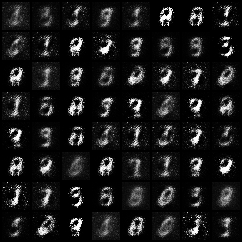

In [103]:
filenames = glob('/content/im/*')
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/content/animation.gif', images, fps=1)
embed.embed_file("animation.gif")

# **Plot 📈**

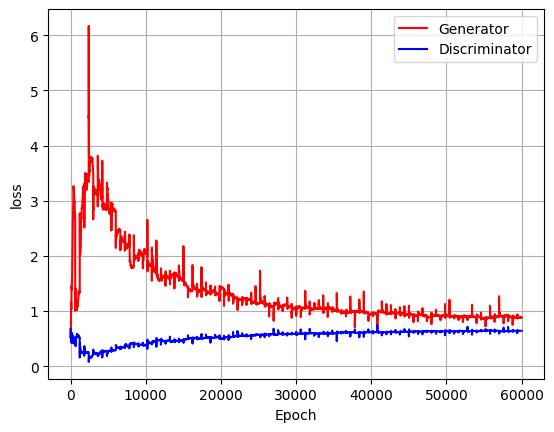

In [57]:
plt.plot(range(len(loss_G_hist)), loss_G_hist, 'r-', label='Generator')
plt.plot(range(len(loss_D_hist)), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# **Save 💰**

In [58]:
torch.save(gen, '/content/Generator.pth')

# **Evaluation ❓**

In [99]:
batch = Variable(torch.randn((3, z_size))).to(device)
fake_labels = Variable(torch.LongTensor([4, 6, 8])).to(device)
model = torch.load('/content/Generator.pth')
output = model(batch, fake_labels).unsqueeze(1).data.cpu()

In [101]:
images = make_grid(output, nrow=3, normalize=True)
save_image(images.view(3, 1, 28, 28), 'final_eval.png')


 4    6    8


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
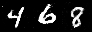

In [102]:
print(' 4    6    8')
imageio.imread('final_eval.png')